In [1]:
from utils.clustering import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import itertools
from typing import Any


In [2]:
class ColorList(object):
    def __init__(self, colorlist=[f'C{i}' for i in range(10)], linestyles=['-', ':', '--', '-.']):
        self.colorlist = colorlist
        self.linestyles = linestyles
        self.combinations = list(itertools.product(self.linestyles, self.colorlist))

In [3]:
class TreeNode(object):
    """
    Tree node class to construct the final tree.
    """
    def __init__(self, index, parent_id=None, children=None, scenario_ids=None, family=None, edge_values=None, domain=None, weight=1, leaf=False):
        self.index = index
        self.parent_id = parent_id

        self.children = children
        self.edge_values = edge_values
        self.domain = domain
        self.scenario_ids = scenario_ids
        self.family = family
        self.weight = weight
        self.is_leaf = leaf

        if self.children is None:
            self.children = []
        if self.edge_values is None:
            self.edge_values = []
        if self.domain is None:
            self.domain = []
        if self.scenario_ids is None:
            self.scenario_ids = []
        if self.family is None:
            self.family = []

    def __getitem__(self, key):
        return self.children[key]
    
    def __iter__(self):
        return iter(self.children)

    def __repr__(self):
        return self._repr_helper(0)

    def _repr_helper(self, indent):
        result = " " * indent
        result += f"Node: {self.index}, Scenarios: {self.scenario_ids}, Weight: {self.weight}, Domain: {self.domain}\n"

        for child in self.children:
            result += child._repr_helper(indent + 4)

        return result
    
    def get_n_timesteps(self):
        return len(np.array(self.get_domains()).flatten())
    
    def get_domains(self, domains=None):
        if domains==None:
            domains = self.domain.copy()
        for child in self.children:
            domains.extend(child.domain)
            child.get_domains(domains)
        return domains

    
    def plot_tree(self, parent=None, ax=None, title=None, parent_color=None, parent_linestyle=None, colorlist=None, return_axes=False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 2))

        if title is not None:
            ax.set_title(title)

        if colorlist is None:
            colorlist = ColorList()
        
        if (parent_color is None) and (parent_linestyle is None):
            parent_color = colorlist.combinations[0][1]
            parent_linestyle = colorlist.combinations[0][0]
            colorlist.combinations = colorlist.combinations[1:]
        elif (parent_color is None) or (parent_linestyle is None):
            raise ValueError("Both parent_color and parent_linestyle should be None or neither of them.")

        if parent is None:
            parent = self
            
            # Plot first node
            ax.step(parent.domain, self.edge_values, linestyle=parent_linestyle, color=parent_color, where='post')
        
        # Plot edges to children
        for i, child in enumerate(parent.children):
            if i == 0:
                child_color = parent_color
                child_linestyle = parent_linestyle
            else:
                child_color = colorlist.combinations[0][1]
                child_linestyle = colorlist.combinations[0][0]
                colorlist.combinations = colorlist.combinations[1:]
            
            # Add these to the plot to prevent gaps
            domain = [parent.domain[-1]] + child.domain
            edge_values = np.concatenate((np.array([parent.edge_values[-1]]), child.edge_values))
            
            ax.step(domain, edge_values, linestyle=child_linestyle, color=child_color, where='post')
            
            if not child.is_leaf:
                # Recursively plot child nodes
                self.plot_tree(parent=child, ax=ax, parent_color=child_color, parent_linestyle=child_linestyle, colorlist=colorlist)
        
        ax.set_xlabel("Hours")
        ax.set_ylabel("Values")
        ax.set_xlim(0, 48)
        ax.set_xticks([0, 12, 24, 36, 48])

        if return_axes:
            return fig, ax
        
    def plot_structure(self, parent=None, ax=None, title=None, colorlist=None, return_axes=False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        if title is not None:
            ax.set_title(title)

        if colorlist is None:
            colorlist = ["blue", "green", "red", "orange", "purple", "brown"]

        if parent is None:
            parent = self

        for i, child in enumerate(parent.children):
            if parent == self:
                x = [i + 0.5]
            else:
                x = [parent.index + 0.5, child.index + 0.5]

            y = [child.get_n_timesteps(), child.get_n_timesteps()]
            ax.plot(x, y, color=colorlist[child.index % len(colorlist)], linewidth=2)

            if not child.is_leaf:
                # Recursively plot child nodes
                self.plot_tree(parent=child, ax=ax, colorlist=colorlist)

        ax.set_xlabel("Node Index")
        ax.set_ylabel("Number of Timesteps")
        ax.set_xticks(range(len(self.children) + 1))
        ax.set_xlim(0, len(self.children))
        ax.set_ylim(0, self.get_n_timesteps() + 1)

        if return_axes:
            return fig, ax


In [4]:
class TreeClusterer():
    """Class to cluster a scenario fan to a tree structure."""

    def __init__(self, scenario_df, method='energy', p=1, node_locations=None, node_sizes=None, verbose=True):
        self.scenario_df = scenario_df.iloc[:, :-1]
        self.weights = scenario_df.iloc[:, -1].values

        self.p = p
        self.x=self.scenario_df.values
        
        self.method = method
        self.node_locations = node_locations if node_locations else []
        self.node_sizes = node_sizes if node_sizes else []
        self.verbose = verbose

    def get_energy_score_weights(self, cluster):
        """
        Get the energy score for a cluster of scenarios.
        """
        
        A_z = np.power(np.array(np.asmatrix(distance.cdist(cluster, cluster, metric='euclidean'))), self.p)
        b = np.power(np.array(np.asmatrix(distance.cdist(cluster, self.x, metric='euclidean'))), self.p)
        b_z = 2*np.dot(b, self.weights)
        
        x0 = np.ones(len(cluster))/len(cluster)
        bounds = [(0, 1) for i in range(len(cluster))]
        res = minimize(fun=lambda x: np.dot(x, b_z) - np.dot(x, np.dot(A_z, x)),
                        x0=x0,
                        method='SLSQP',
                        bounds=bounds,
                        constraints={'type': 'eq', 'fun': lambda x: np.sum(x)-1})
        x_z = res.x
        obj_val = np.power(res.fun, 1/self.p)
        return [obj_val, x_z]

    
    def get_node_scenarios(self, column):
        # Get the unique values of the node
        unique_values = self.scenario_slice.iloc[:, column].dropna()
        
        # Get the indices of the scenarios per value
        indices = [self.scenario_tree.index[self.scenario_tree.iloc[:, column] == value].tolist() for value in unique_values]
        return indices
    
    def get_children_(self, column, parent):
        # Get the indices of non-NaN scenarios that are possible for this node
        unique_values = self.scenario_slice.iloc[:, column].dropna()
        
        # Get the indices of the possible children (= non-nan scenario at node)
        scenario_options = sum([self.scenario_slice.index[self.scenario_slice.iloc[:, column] == value].tolist() for value in unique_values], [])
        
        # Get the indices of the scenarios that need to be added to a child
        scenarios_to_merge = self.scenario_slice.index[self.scenario_slice.iloc[:, column].isna()].tolist()

        # # Check if the child scenario is completely NaN
        # for id_ in parent.scenario_ids:
        #     if self.scenario_slice.iloc[id_, :].isna().all():
        #         parent.scenario_ids.remove(id_)
                
        # Get the scenario indices in the parent node
        parent_scenarios = parent.scenario_ids

        # Filter the possible children to only include scenarios that are in the parent node
        scenario_options = [child for child in scenario_options if child in parent_scenarios]
        scenarios_to_merge = [child for child in scenarios_to_merge if child in parent_scenarios]
        
        return (scenario_options, scenarios_to_merge)
    
    def get_leaf_node(self, scenario_id, index=0, parent_id=None, weight=1):
        # Get the leaf node of the scenario
        prevcol = self.node_locations[-1]
        return TreeNode(
            index=index,
            domain=[c for c in range(prevcol, len(self.scenario_slice.columns))],
            family=None,
            scenario_ids=[scenario_id],
            edge_values=self.scenario_slice.iloc[scenario_id, prevcol:].values.flatten(),
            weight=weight,
            parent_id=parent_id,
            leaf=True
        )

    def generate_nodes(self, parent=None, level=0):
        if parent is None:
            # Make the root node with domain loc[0] - loc[1] (0, 1, 2, 3)
            self.scenario_tree_df = self.scenario_slice.copy().dropna(axis=0, how='all')
            parent = TreeNode(
                index=0, 
                domain=[c for c in range(self.node_locations[0], self.node_locations[1]+1)], #[c for c in self.scenario_tree_df.index],#
                family=self.scenario_slice.index.tolist(), 
                scenario_ids=self.scenario_slice.index.tolist(),
                edge_values=self.scenario_slice.iloc[:, self.node_locations[0]:self.node_locations[1]+1].dropna().values.flatten()
                )
            
            # Add the root node data to the DataFrame
            self.scenario_tree_df.iloc[:, self.node_locations[0]:self.node_locations[1]+1] = np.concatenate([parent.edge_values for _ in self.scenario_tree_df.index]).reshape(len(self.scenario_tree_df.index), -1)
            level += 1
        
        # Check if we are in a leaf node
        if level == len(self.node_locations)-1:
            # Add the leaves to the parent
            weights = [self.weights[i] for i in parent.scenario_ids]
            for i, scenario_id in enumerate(parent.scenario_ids):
                parent.children.append(self.get_leaf_node(
                    scenario_id=scenario_id, 
                    index=i,
                    parent_id=parent.index,
                    weight=np.round(weights[i]/sum(weights), decimals=2)
                    ))
                edge_values = parent.children[-1].edge_values
                self.scenario_tree_df.iloc[scenario_id, self.node_locations[-1]:] = edge_values
            return parent
        
        # Now move up a level every time, starting at 1, with domain starting at loc[1]+1 end at loc[2] (4, 5, 6, 7, 8)
        # Get the end column of the node
        col = self.node_locations[level + 1]  # col[2] (8) At column 'col' is the last columne where n_scenarios = n_splits[col]
        prev_col = self.node_locations[level] + 1 #  col[1] (4)
        
        # Get the indices of the scenarios grouped per unique value
        child_scenario_indices, children_to_merge = self.get_children_(col, parent)
        
        # Group the children based on the Euclidean distance between the edge values
        child_groups = [[i] for i in child_scenario_indices]

        for i, child_to_merge in enumerate(children_to_merge):
            # Original (removed) edge values of the child
            og_edge_values = self.scenario_df.iloc[child_to_merge, prev_col:col+1].values.flatten()
            # print(og_edge_values)

            # Calculate the euclidean distance between the edge values and the possible nodes
            distances = [distance.euclidean(og_edge_values, self.scenario_slice.iloc[index, prev_col:col+1].values.flatten()) for index in child_scenario_indices]

            # Get the index of the closest node
            scen_nr = np.argmin(distances)
            closest_index = child_scenario_indices[scen_nr]

            # Add the scenario to the closest node
            child_groups[scen_nr].append(child_to_merge)

            # Get the edge values of the closest node
            edge_values = self.scenario_slice.iloc[closest_index, prev_col:col+1].values.flatten()

            # Fill the scenario tree dataframe
            # print(child_to_merge, prev_col, col, edge_values)
            # print(self.scenario_tree_df.loc[child_to_merge])
            self.scenario_tree_df.iloc[child_to_merge, prev_col:col+1] = edge_values

        # Calculate the weights in the groups
        weights = [sum([self.weights[i] for i in index]) for index in child_groups]
        weights = [np.round(weight/sum(weights), decimals=2) for weight in weights]

        for i, child_group in enumerate(child_groups):
            # Add the child node to the parent
            treenode = TreeNode(
                index=i,
                parent_id=parent.index,
                domain=[c for c in range(prev_col, col+1)],
                family=child_group,
                scenario_ids=child_group,
                edge_values=self.scenario_slice.iloc[child_group[0], prev_col:col+1].values.flatten(),
                weight=weights[i]
            )
            parent.children.append(treenode)

            # Recursively generate the child nodes
            self.generate_nodes(parent=treenode, level=level+1)

        return parent
    
    def reduce_redundant_nodes(self, parent):
        # Loop through the children and check if they are identical to the parent (scenario_ids).
        # If so, remove the child and add the domain to the parents domain, and add the children to the parent.
        for child in parent.children:
            if set(child.scenario_ids) == set(parent.scenario_ids):
                parent.domain = parent.domain + child.domain
                parent.children = parent.children + child.children
                parent.children.remove(child)
                parent.edge_values = np.concatenate((parent.edge_values, child.edge_values))
                self.reduce_redundant_nodes(parent)
                if child.is_leaf:
                    parent.is_leaf = True
                break
            elif set(child.scenario_ids) == set():
                parent.children.remove(child)
                self.reduce_redundant_nodes(parent)
                if child.is_leaf:
                    parent.is_leaf = True
            else:
                self.reduce_redundant_nodes(child)
        return parent

    def generate_tree(self, node_locations=None, split_sizes=None, method='energy'):
        """
        Reduce the tree by removing nodes.
        The part untill the first mentioned node is assumed to be a single scenario.
        If the last node is not mentioned, the last split size is assumed to be the size of the whole set.

        Parameters
        ----------
        split_locations : list of int
            Locations of the splits in the tree.
        split_sizes : list of int
            Sizes of the splits in the tree.
        """    
        if node_locations is None:
            node_locations = sorted([l for l in self.node_locations], reverse=True)
        else:
            self.node_locations = sorted([l for l in node_locations])

        if split_sizes is None:
            split_sizes = sorted([s for s in self.node_sizes], reverse=True)
        else:
            self.node_sizes = sorted([s for s in split_sizes])

        if len(node_locations) == 0:
            return self.scenario_df
        if len(node_locations) != len(split_sizes):
            raise ValueError('Length of node_locations and split_sizes should be equal.')
        

        # Sort the nodes and split sizes, largest sizes should be first in iteration
        # The largest size should be with the last node
        node_locations = sorted([loc for loc in node_locations], reverse=True)
        split_sizes = sorted([s for s in split_sizes], reverse=True)

        # Make a copy of the scenario dataframe
        # This will be made NaN if the scenario is assigned to a parent, for the domain of that parent
        self.scenario_slice = self.scenario_df.copy()
        
        # Loop through the nodes and cluster the scenarios
        # CHANGED
        if self.verbose:
            iterator = tqdm(node_locations[:-1])
        else:
            iterator = node_locations[:-1]
            # iterator = node_locations

        for i, node in enumerate(iterator):
            
            # subset_size = split_sizes[1:][i] CHANGED
            subset_size = split_sizes[i]
            to_cluster = self.scenario_slice.copy().iloc[:, :node+1].dropna()
            
            # print(node, subset_size)
            if subset_size < len(to_cluster):
                clusterer = ReduceForward(x=to_cluster.values, cdn=subset_size, dist=method, verbose=False)
                clusterer.reduce_forward()
                
                clustered_scen_ids = self.scenario_slice.iloc[:, :node+1].dropna().index[clusterer.tracker[subset_size-1]['scenario_set']]
                children_to_merge = [scen_id for scen_id in to_cluster.index.to_list() if (scen_id not in clustered_scen_ids)]
                
                for scen_id in children_to_merge:
                    self.scenario_slice.iloc[scen_id, :node+1] = np.nan
                
                # self.scenario_slice.iloc[children[-1], :node] = np.nan
            elif subset_size == len(to_cluster):
                continue
            else:
                raise ValueError('Subset size should be smaller than the number of possible scenarios in the node.')
            # print(self.scenario_slice)

        # Make a tree data-structure
        self.scenario_slice = self.scenario_slice.dropna(how='all')
        self.scenario_slice = self.scenario_slice.reset_index(drop=True)
        self.tree = self.generate_nodes()
        self.tree = self.reduce_redundant_nodes(self.tree)

        # Get the weights of the scenarios
        score_weights = self.get_energy_score_weights(self.scenario_tree_df.values)
        self.energy_score = score_weights[0]
        self.fitted_weights = score_weights[1]
        self.scenario_tree_df['weights'] = self.fitted_weights
        self.scenario_tree_df = self.scenario_tree_df.round(2)

    def redistribute_weights(self, parent):
        """
        Redistribute the weights of the scenarios in the tree.
        Has to be called again after a part of the scenarios is deleted.
        """
        if parent.is_leaf:
            parent.weight = 1

        children_scenario_ids = [child.scenario_ids for child in parent.children]
        children_weights = [self.fitted_weights[children_scenario_ids[i]] for i in range(len(children_scenario_ids))]

        for i, child in enumerate(parent.children):
            child.weight = children_weights[i] / np.sum(children_weights)
            self.redistribute_weights(child)
        

In [5]:
T = 5
scenarios = pd.DataFrame(index=range(2**T), columns=range(T+1), dtype=float)

steps = [i for i in product([-1,1], repeat=T)]
for t in range(2**T):
    scenarios.iloc[t, :] = np.cumsum([0] + list(steps[t]))

In [6]:
energy_clusterer = ReduceForward(
    x=scenarios.values,
    cdn=5,
    dist='energy',
    parallel=False,
)

wasserstein_clusterer = ReduceForward(
    x=scenarios.values,
    cdn=5,
    dist='wasserstein',
    parallel=False,
)

In [7]:
energy_clusterer.reduce_forward()
wasserstein_clusterer.reduce_forward()

100%|██████████| 28/28 [00:00<00:00, 4664.04it/s]


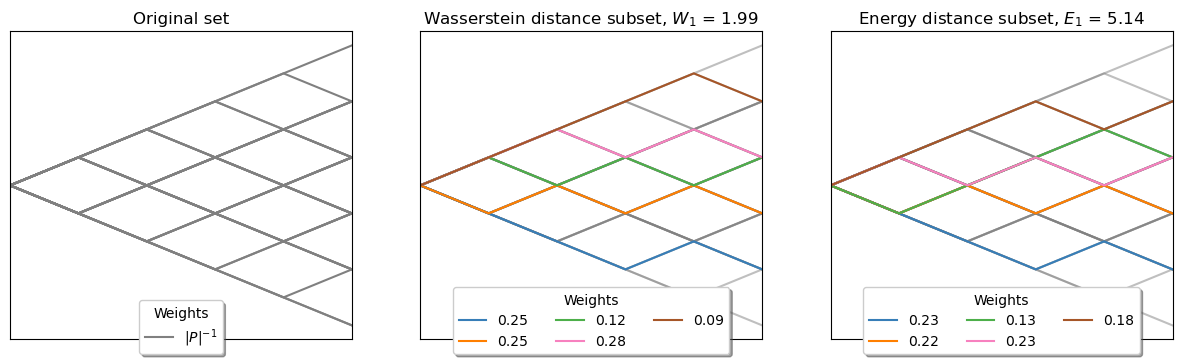

In [8]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(scenarios.T, color='grey')
ax[0].plot(scenarios.T.iloc[:,0], color='grey', label='$|P|^{-1}$')
ax[0].set_title('Original set')
ax[0].set_xlim(0, 5)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=3, title='Weights', fancybox=True, shadow=True)
# ax[0].axis('off')

wass_scenarios = wasserstein_clusterer.clusters.iloc[:, :-1].T
wass_weights = wasserstein_clusterer.clusters.round(2).iloc[:, -1]
ax[1].plot(scenarios.T, color='grey', alpha=0.5)
for i, (s, w) in enumerate(zip(wass_scenarios.index, wass_weights)):
    ax[1].plot(wass_scenarios[s], label=w, color=CB_color_cycle[i])
ax[1].set_title('Wasserstein distance subset, $W_1$ = {}'.format(np.round(wasserstein_clusterer.tracker[4]['score'], decimals=2)))
ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=3, title='Weights', fancybox=True, shadow=True)
ax[1].set_xlim(0, 5)
ax[1].set_xticks([])
ax[1].set_yticks([])

energy_scenarios = energy_clusterer.clusters.iloc[:, :-1].T
energy_weights = energy_clusterer.clusters.round(2).iloc[:, -1]
ax[2].plot(scenarios.T, color='grey', alpha=0.5)
for i, (s, w) in enumerate(zip(energy_scenarios.columns, energy_weights)):
    ax[2].plot(energy_scenarios[s], label=w, color=CB_color_cycle[i])
ax[2].set_title('Energy distance subset, $E_1$ = {}'.format(np.round(energy_clusterer.tracker[4]['score'], decimals=2)))
ax[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=3, title='Weights', fancybox=True, shadow=True)
ax[2].set_xlim(0, 5)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.savefig('figures/bernoulli_walk.pdf', bbox_inches='tight')


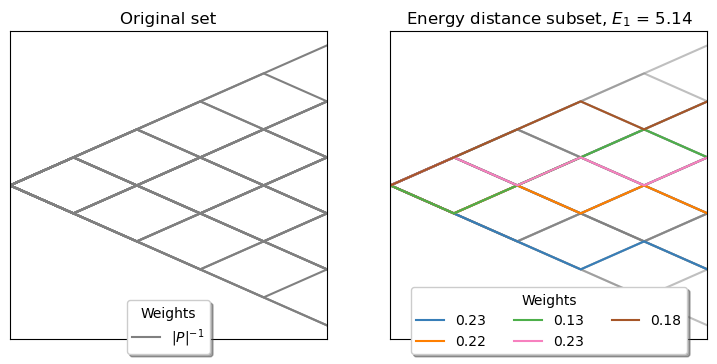

In [16]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(scenarios.T, color='grey')
ax[0].plot(scenarios.T.iloc[:,0], color='grey', label='$|P|^{-1}$')
ax[0].set_title('Original set')
ax[0].set_xlim(0, 5)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=3, title='Weights', fancybox=True, shadow=True)
# ax[0].axis('off')

energy_scenarios = energy_clusterer.clusters.iloc[:, :-1].T
energy_weights = energy_clusterer.clusters.round(2).iloc[:, -1]
ax[1].plot(scenarios.T, color='grey', alpha=0.5)
for i, (s, w) in enumerate(zip(energy_scenarios.columns, energy_weights)):
    ax[1].plot(energy_scenarios[s], label=w, color=CB_color_cycle[i])
ax[1].set_title('Energy distance subset, $E_1$ = {}'.format(np.round(energy_clusterer.tracker[4]['score'], decimals=2)))
ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=3, title='Weights', fancybox=True, shadow=True)
ax[1].set_xlim(0, 5)
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.savefig('figures/bernoulli_walk.pdf', bbox_inches='tight')


In [9]:
scenarios.iloc[:,:-5]

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [10]:
tree_df = pd.DataFrame(index=energy_scenarios.columns, columns=energy_scenarios.index)

temp_scen = energy_scenarios.T.copy().astype(float)
removed_scenarios = []
# Split the scenarios at column 3 into 4 scenario
temp_ = temp_scen.iloc[:, :3].copy()
clusterer = ReduceForward(
    x=temp_.values,
    cdn=4,
    dist='energy',
    parallel=False,
)
clusterer.reduce_forward()
scenario_index = clusterer.tracker[3]['scenario_set']
scenario_indices = temp_.iloc[scenario_index, :].index
removed_scenario = temp_.loc[~temp_.index.isin(scenario_index), :].index[0]
removed_scenarios.append(removed_scenario)

temp_scen.loc[removed_scenario, :3] = np.nan

# Split the scenarios at column 2 into 3 scenarios
temp_ = temp_scen.iloc[:, :2].copy().dropna()
clusterer = ReduceForward(
    x=temp_.values,
    cdn=3,
    dist='energy',
    parallel=False,
)
clusterer.reduce_forward()
scenario_index = clusterer.tracker[2]['scenario_set']
scenario_indices = temp_.iloc[scenario_index, :].index
removed_scenario = temp_.loc[~temp_.index.isin(scenario_index), :].index[0]
removed_scenarios.append(removed_scenario)

temp_scen.loc[removed_scenario, :2] = np.nan

# Split the scenarios at column 1 into 2 scenarios
temp_ = temp_scen.iloc[:, :1].copy().dropna()
clusterer = ReduceForward(
    x=temp_.values,
    cdn=2,
    dist='energy',
    parallel=False,
)
clusterer.reduce_forward()
scenario_index = clusterer.tracker[1]['scenario_set']
scenario_indices = temp_.iloc[scenario_index, :].index
removed_scenario = temp_.loc[~temp_.index.isin(scenario_index), :].index[0]
removed_scenarios.append(removed_scenario)

temp_scen.loc[removed_scenario, :1] = np.nan

# Split the scenarios at column 0 into 1 scenarios
temp_ = temp_scen.iloc[:, [0]].copy().dropna()
clusterer = ReduceForward(
    x=temp_.values,
    cdn=1,
    dist='energy',
    parallel=False,
)
clusterer.reduce_forward()
scenario_index = clusterer.tracker[0]['scenario_set']
scenario_indices = temp_.iloc[scenario_index, :].index
removed_scenario = temp_.loc[~temp_.index.isin(scenario_index), :].index[0]
removed_scenarios.append(removed_scenario)

temp_scen.loc[removed_scenario, 0] = np.nan


100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


In [11]:
# Fill the dataframe with the closes scenario
filled_tree = temp_scen.copy().T
filled_tree.iloc[3, 2] = 3
filled_tree.iloc[2, 2] = 2
filled_tree.iloc[2, 3] = 0
filled_tree.iloc[1, :] = -1
filled_tree.iloc[0,:] = 0


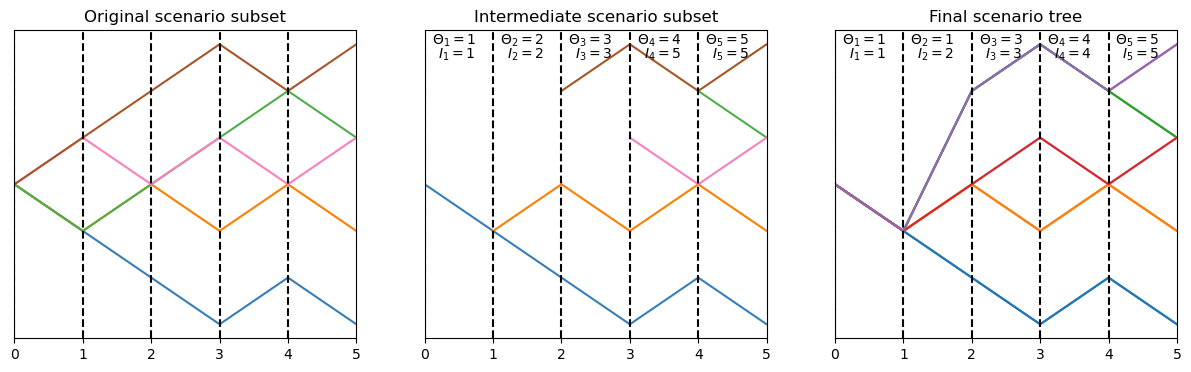

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(len(energy_scenarios.columns)):
    ax[0].plot(energy_scenarios.loc[:,i], color=CB_color_cycle[i])
    ax[1].plot(temp_scen.T.loc[:,i], color=CB_color_cycle[i])
    ax[2].plot(filled_tree.loc[:,i], color=CB_color_cycle[i])

ax[0].axvline(0, color='black', linestyle='--')
ax[0].axvline(1, color='black', linestyle='--')
ax[0].axvline(2, color='black', linestyle='--')
ax[0].axvline(3, color='black', linestyle='--')
ax[0].axvline(4, color='black', linestyle='--')
# ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original scenario subset')
ax[0].set_xlim(0,5)


ax[1].axvline(0, color='black', linestyle='--')
ax[1].text(0.1, 3, '$\Theta_1=1$')
ax[1].text(0.2, 2.7, '$I_1=1$')
ax[1].axvline(1, color='black', linestyle='--')
ax[1].text(1.1, 3, '$\Theta_2=2$')
ax[1].text(1.2, 2.7, '$I_2=2$')
ax[1].axvline(2, color='black', linestyle='--')
ax[1].text(2.1, 3, '$\Theta_3=3$')
ax[1].text(2.2, 2.7, '$I_3=3$')
ax[1].axvline(3, color='black', linestyle='--')
ax[1].text(3.1, 3, '$\Theta_4=4$')
ax[1].text(3.2, 2.7, '$I_4=5$')
ax[1].axvline(4, color='black', linestyle='--')
ax[1].text(4.1, 3, '$\Theta_5=5$')
ax[1].text(4.2, 2.7, '$I_5=5$')
# ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Intermediate scenario subset')
ax[1].set_xlim(0,5)

ax[2].plot(filled_tree)
ax[2].axvline(0, color='black', linestyle='--')
ax[2].text(0.1, 3, '$\Theta_1=1$')
ax[2].text(0.2, 2.7, '$I_1=1$')
ax[2].axvline(1, color='black', linestyle='--')
ax[2].text(1.1, 3, '$\Theta_2=1$')
ax[2].text(1.2, 2.7, '$I_2=2$')
ax[2].axvline(2, color='black', linestyle='--')
ax[2].text(2.1, 3, '$\Theta_3=3$')
ax[2].text(2.2, 2.7, '$I_3=3$')
ax[2].axvline(3, color='black', linestyle='--')
ax[2].text(3.1, 3, '$\Theta_4=4$')
ax[2].text(3.2, 2.7, '$I_4=4$')
ax[2].axvline(4, color='black', linestyle='--')
ax[2].text(4.1, 3, '$\Theta_5=5$')
ax[2].text(4.2, 2.7, '$I_5=5$')
# ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Final scenario tree')
ax[2].set_xlim(0,5)

plt.savefig('figures/bernoulli_tree.pdf', bbox_inches='tight')


In [204]:
clusterer = ReduceForward(
    x=filled_tree.T.values,
    cdn=5,
    dist='energy',
    parallel=False,
)
clusterer.reduce_forward()

100%|██████████| 1/1 [00:00<00:00, 765.24it/s]


In [206]:
clusterer.tracker[4]

{'scenario_set': array([0, 1, 2, 3, 4]),
 'weights': array([0.2, 0.2, 0.2, 0.2, 0.2]),
 'score': 4.287706593582712}

In [192]:
filled_tree

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,-1.0,-1.0,-1.0
2,-2.0,0.0,2.0,0.0,2.0
3,-3.0,-1.0,3.0,1.0,3.0
4,-2.0,0.0,2.0,0.0,2.0
5,-3.0,-1.0,1.0,1.0,3.0


In [193]:
temp_scen.T

,0,1,2,3,4
0,0.0,NaN,NaN,NaN,NaN
1,-1.0,-1.0,NaN,NaN,NaN
2,-2.0,0.0,NaN,NaN,2.0
3,-3.0,-1.0,NaN,1.0,3.0
4,-2.0,0.0,2.0,0.0,2.0
5,-3.0,-1.0,1.0,1.0,3.0


<Axes: >

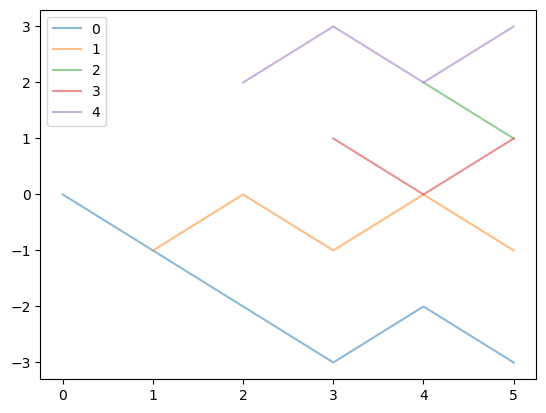

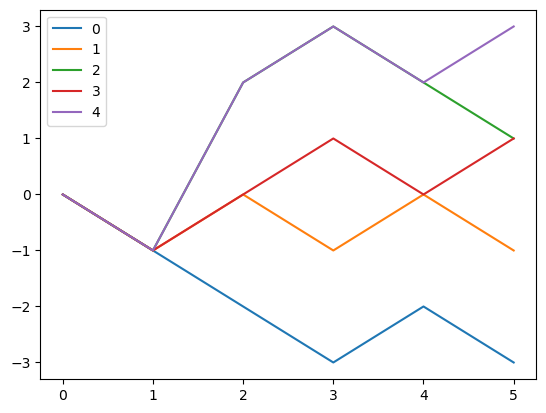

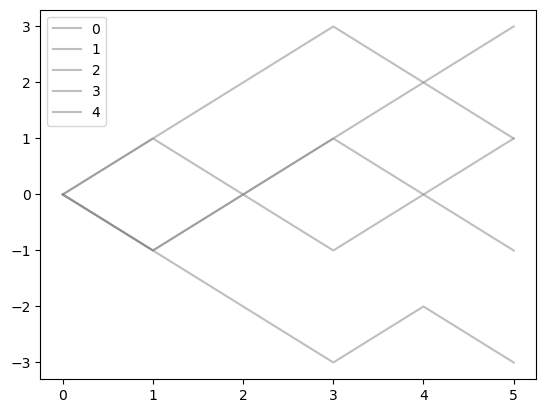

In [194]:
temp_scen.T.plot(alpha=0.5)
filled_tree.plot()
energy_scenarios.plot(color='grey', alpha=0.5)

In [109]:
tc = TreeClusterer(energy_scenarios.T.astype(float), verbose=True)
problem = ScenarioTreeOptimizationProblem(
    scenarios=energy_scenarios.T,
    n_leafs=len(energy_scenarios.T.index),
    n_splits=3,
    constrain_complexity=True,
    complexity_reduction_factor=0.5
)

node_locations = [0, 1, 3, 4]
split_sizes = [1, 2, 3, 5]

# node_locations, split_sizes = problem.format_node_split(node_locations, split_sizes)
print(node_locations, split_sizes)

Number of variables: 6
Number of objectives: 1
[3 3 3 1 1 1]
[0, 1, 3, 4] [1, 2, 3, 5]


In [110]:
tc.generate_tree(node_locations, split_sizes)

100%|██████████| 3/3 [00:25<00:00,  8.41s/it]


ValueError: could not broadcast input array from shape (5,4) into shape (5,2)

In [74]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize as minimize_pymoo
from pymoo.core.problem import Problem

In [75]:
class ScenarioTreeOptimizationProblem(Problem):
    def __init__(self, scenarios, n_leafs, n_splits, constrain_complexity=False, complexity_reduction_factor=0.5, n_root_scenario_steps=3):
        self.n_leafs = n_leafs
        self.scenarios = scenarios

        self.constrain_complexity = constrain_complexity
        self.complexity_reduction_factor = complexity_reduction_factor
        self.max_complexity = int(np.ceil(n_leafs * len(scenarios.columns) * complexity_reduction_factor))

        self.n_splits = n_splits

        # Define the bounds 
        # lower: min location is the hour where more than 1 scenario can occur: [n_root_scenario_steps] * n_splits -1
        #       + the last hour (added manually later)
        #       + the size of the first split [1] (added manually later)
        #       + the min size of the splits: [1] * n_splits
        #      +  the last split size: [1]
        xl = np.array(
            # [0] + [loc] * n_splits + [47] + [1, 1] + [split_size] * n_splits
            [n_root_scenario_steps for i in range(self.n_splits)] + [1 for i in range(self.n_splits)])

        # upper: max location is the second-last hour: [46] * n_splits
        #       + the last hour (added manually later)
        #       + the size of the first split [1] (added manually later) 
        #       + the max size of the splits: [n_leafs] * n_splits
        #       + the last split size: [n_leafs]
        xu = np.array([46 for i in range(self.n_splits)] + [self.n_leafs for i in range(self.n_splits)])

        # bounds: n_locs = n_splits, n_sizes = n_splits + 1

        n_var = len(xl)
        n_obj = 1
        n_constr = 1 if self.constrain_complexity else 0

        print(f'Number of variables: {n_var}')
        print(f'Number of objectives: {n_obj}')
        print(xl)
        
        super().__init__(
            n_var=n_var, n_obj=n_obj, n_ieq_constr=n_constr,
            xl=xl, xu=xu)

    def format_node_split(self, node_locations, split_sizes):
        node_locations = np.sort(np.array(node_locations, dtype=int))
        split_sizes = np.sort(np.array(split_sizes, dtype=int))

        node_locations = np.append(node_locations, [47])
        split_sizes = np.append([1], split_sizes)

        # print('Original')
        # print(node_locations)
        # print(split_sizes)
        # print('-----------------')
        unique_node_locations = np.unique(node_locations)
        unique_split_sizes = np.unique(split_sizes)

        # print('Unique')
        # print(unique_node_locations)
        # print(unique_split_sizes)
        # print('-----------------')

        temp_node_locations = np.empty(len(unique_node_locations), dtype=int)
        temp_split_sizes = np.empty(len(unique_node_locations), dtype=int)
        # print(temp_split_sizes)
        for i, loc in enumerate(unique_node_locations):
            # Get all indices of the node locations
            indices = np.where(node_locations == loc)[0]
            # Get the splits of all nodes with the same location
            splits = split_sizes[indices]
            # Get the minimum split of all nodes with the same location
            temp_split_sizes[i] = np.min(splits)
            # Update the temp lists
            temp_node_locations[i] = loc
            # print('in between, loc: ', loc)
            # print(indices)
            # print(splits)
            # print(temp_split_sizes)
            # print('-' * 10)

        unique_split_sizes = np.unique(temp_split_sizes)
        
        # print('Temp')
        # print(temp_node_locations)
        # print(temp_split_sizes)
        # print(unique_split_sizes)
        # print('-----------------')
        # Repeat the same process for the split sizes
        new_node_locations = np.empty(len(unique_split_sizes), dtype=int)
        new_split_sizes = np.empty(len(unique_split_sizes), dtype=int)

        for i, split in enumerate(unique_split_sizes):
            # Get all indices of the node locations
            indices = np.where(temp_split_sizes == split)[0]
            # Get the locations of all nodes with the same split size
            nodes = temp_node_locations[indices]
            # Get the maximum locations of all nodes with the same split size
            new_node_locations[i] = np.max(nodes)
            # Update the temp lists
            new_split_sizes[i] = split

        # print('New')
        # print(new_node_locations)
        # print(new_split_sizes)
        # print('-----------------')

        # Add the root node
        new_node_locations = np.append([0], new_node_locations)
        # new_node_locations = np.append(new_node_locations, [47])
        new_split_sizes = np.append([1], new_split_sizes)

        # print('Final')

        return sorted(list(new_node_locations)), sorted(list(new_split_sizes))
    
    def check_non_decreasing(self, x):
        """
        Checks whether the tree size is non-decreasing.
        """
        for i in range(len(x)-1):
            if x[i] >= x[i+1]:
                return False
        return True
    
    def complexity_constraint(self, locs, splits):
        """
        Checks for the amount of decision variables in the tree.
        """
        if self.get_complexity(locs, splits) > self.max_complexity:
            return False
        return True
    
    def get_complexity(self, locs, splits):
        complexity = 0
        for i in range(len(locs)-1):
            complexity += splits[i+1]*(locs[i+1] - locs[i])
        
        # complexity += splits[-1]*(47 - locs[-1])
        return complexity
    
    def eval_tree(self, x):
        x = np.array(x, dtype=int)

        # bounds: n_locs = n_splits, n_sizes = n_splits + 1
        node_locations = x[:self.n_splits]
        split_sizes = x[self.n_splits:]
        # print(x)
        # print(node_locations)
        # print(split_sizes)
        # print('-----------------')
        node_locations, split_sizes = self.format_node_split(node_locations, split_sizes)
        # print(node_locations)
        # print(split_sizes)
        # print()


        constr = []
        if self.constrain_complexity:
            constr = np.append(constr, self.complexity_constraint(node_locations, split_sizes))

        if not np.all(constr):
            return np.array([np.inf]), 1 - constr
        
        tc = TreeClusterer(self.scenarios, verbose=False)
        tc.generate_tree(
            node_locations=node_locations,
            split_sizes=split_sizes,
            method='energy'
        )
        objs = np.array([tc.energy_score])
        
        return objs, 1 - constr

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Optimize the tree.
        """
        # Generate a tree
        # Root node is always at 0 and size always 1
        res = np.empty((len(x), 1+self.n_constr))
        for i in range(len(x)):
            obj, constr = self.eval_tree(x[i])
            res[i,0] = obj
            res[i,1:] = constr

        objs = res[:,0]
        constr = res[:,1:]
        
        out['F'] = objs
        out['G'] = constr

In [81]:
problem = ScenarioTreeOptimizationProblem(
    scenarios=energy_scenarios.T,
    n_leafs=len(energy_scenarios.T.index),
    n_splits=3,
    constrain_complexity=True,
    complexity_reduction_factor=0.5
)

Number of variables: 6
Number of objectives: 1
[3 3 3 1 1 1]


In [82]:
energy_scenarios

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,-1.0,1.0,1.0
2,-2.0,0.0,0.0,0.0,2.0
3,-3.0,-1.0,1.0,1.0,3.0
4,-2.0,0.0,2.0,0.0,2.0
5,-3.0,-1.0,1.0,1.0,3.0


In [83]:
algorithm = GA(
    pop_size=30,
    eliminate_duplicates=True
)

In [ ]:
res = minimize_pymoo(
    problem=problem,
    algorithm=algorithm,
    # termination=('n_gen', 500),
    termination=('time', '00:00:05'),
    seed=100,
    verbose=True
)

In [79]:
tc = TreeClusterer(scenarios, verbose=True)
node_locations = list(res.X[:problem.n_splits])
split_sizes = list(res.X[problem.n_splits:])
node_locations, split_sizes = problem.format_node_split(node_locations, split_sizes)

tc.generate_tree(
    node_locations=node_locations,
    split_sizes=split_sizes,
    method='energy'
)

TypeError: 'NoneType' object is not subscriptable

In [72]:
tc.scenario_tree_df

,0,1,2,3,4
0,0.0,-1.0,-2.0,-3.0,-2.0
1,0.0,-1.0,0.0,-1.0,0.0
2,NaN,NaN,NaN,1.0,0.0


In [66]:
energy_scenarios

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,-1.0,1.0,1.0
2,-2.0,0.0,0.0,0.0,2.0
3,-3.0,-1.0,1.0,1.0,3.0
4,-2.0,0.0,2.0,0.0,2.0
5,-3.0,-1.0,1.0,1.0,3.0
